In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import eventx
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import io
import pickle

from pathlib import Path
from typing import List
from itertools import chain, accumulate
from tqdm import tqdm

from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.predictors import experimental_ace_predictor
from eventx.util import scorer, utils, evaluate, corpus_statistics

from allennlp.predictors import Predictor

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rcParams["font.family"] = "Palatino"
plt.rcParams['pdf.fonttype'] = 42
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# round to two decimal places in python pandas 
pd.options.display.float_format = '{:.2f}'.format
try:
    pd.set_option('display.max_colwidth', None)
except:    
    pd.set_option('display.max_colwidth', -1)

In [4]:
CUDA_DEVICE = -1  # or -1 if no GPU is available

In [5]:
# Change paths
DATASET_PATH = Path("../../data/ace")
train = DATASET_PATH.joinpath("train.json")
dev = DATASET_PATH.joinpath("dev.json")
test = DATASET_PATH.joinpath("test.json")

SAVE_PATH = Path("../../data/save_files")                     
                    
PREDICTOR_NAME = "experimental-ace-eventx-predictor"

In [6]:
ace_train = pd.read_json(train, encoding='utf8')
ace_dev = pd.read_json(dev, encoding='utf8')
ace_test = pd.read_json(test, encoding='utf8')

## Event extraction evaluation using correctness criteria defined by Ji, Heng and Grishman, Ralph 2008

Ji, Heng and Grishman, Ralph (2008). Refining event extraction through cross-document inference.
> - A trigger is correctly labeled if its event type and offsets match a reference trigger.
> - An argument is correctly identified if its event type and offsets match any of the reference argument mentions.
> - An argument is correctly identified and classified if its event type, offsets, and role match any of the reference argument mentions.

The main difference to the previous evaluation method lies in the correctness criteria for the arguments. Here we additionally consider the correctness of the event type for the argument.

Caution:
Using the following methods to retrieve the triggers and arguments from the gold data might result in duplicate gold triggers & arguments.
This is due to different events possibly sharing the same trigger.
The model is not able to distinguish such events and instead fuses them all together, which results in lower recall.
If we remove duplicates from the gold triggers and gold arguments, recall and consequently f1 should be higher.

In [7]:
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

In [8]:
test_docs = ace_test.to_dict(orient='records')

In [9]:
gold_triggers = scorer.get_triggers(test_docs, events_key='golden-event-mentions')
gold_arguments = scorer.get_arguments(test_docs, events_key='golden-event-mentions')
print(f'Number of gold triggers: {len(gold_triggers)}')
print(f'Number of gold arguments: {len(gold_arguments)}')

Number of gold triggers: 422
Number of gold arguments: 892


In [10]:
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))
    print(f'After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger')
    print(f'Number of unique gold triggers: {len(gold_triggers)}')
    print(f'Number of unique gold arguments: {len(gold_arguments)}')

After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger
Number of unique gold triggers: 422
Number of unique gold arguments: 889


### 3 Repeated Runs
3 repeated runs for each configuration with random seeds for the snorkel label models and eventx model.
Metrics are given as mean & standard deviation.

In [11]:
model_base_path = Path("../../data/runs/ace_rr_experimental")
model_names = [
    "run_27916", "run_44184", "run_54360"
]
trigger_metrics_rr, argument_metrics_rr = {}, {}
model_paths = [model_base_path.joinpath(model_name) for model_name in model_names]
trigger_metrics_rr, argument_metrics_rr = evaluate.summize_multiple_runs(model_paths, test_docs, 
                                                                         predictor_name=PREDICTOR_NAME, 
                                                                         events_key="golden-event-mentions",
                                                                          include_class_metrics=False)

2020-12-07 23:16:59,021 - Collecting metrics for the 3 models
2020-12-07 23:16:59,022 - Working on 1. model.
100%|██████████| 45/45 [01:04<00:00,  1.43s/it]
2020-12-07 23:18:14,350 - Working on 2. model.
100%|██████████| 45/45 [01:09<00:00,  1.54s/it]
2020-12-07 23:19:29,899 - Working on 3. model.
100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


In [12]:
trigger_related_categories = ["Trigger identification", "Trigger classification"]
role_related_categories = ["Argument identification", "Argument classification"]

In [13]:
formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics_rr), make_string=True)
formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics_rr), make_string=True)
formatted_metrics = pd.concat([formatted_trigger, formatted_argument])

In [14]:
formatted_metrics.set_index('row_name')

,precision,recall,f1-score,support
row_name,,,,
Trigger identification,70.1+/- 1.9,70.5+/- 3.6,70.2+/- 1.2,422
Trigger classification,66.3+/- 2.3,66.7+/- 2.7,66.4+/- 0.4,422
Argument identification,40.4+/- 1.4,39.0+/- 1.3,39.6+/- 0.9,889
Argument classification,35.5+/- 2.1,34.2+/- 1.5,34.8+/- 1.6,889


### Statistics about the ACE data

In [15]:
train_stats = {'Split': 'Train'}
train_stats.update(corpus_statistics.get_docs_tokens_entities_events(ace_train))
train_stats.update(corpus_statistics.get_ace_event_stats(ace_train))

dev_stats = {'Split': 'Dev'}
dev_stats.update(corpus_statistics.get_docs_tokens_entities_events(ace_dev))
dev_stats.update(corpus_statistics.get_ace_event_stats(ace_dev))

test_stats = {'Split': 'Test'}
test_stats.update(corpus_statistics.get_docs_tokens_entities_events(ace_test))
test_stats.update(corpus_statistics.get_ace_event_stats(ace_test))

stats = pd.DataFrame([train_stats, dev_stats, test_stats])

In [16]:
general_stats = stats.drop(['Trigger class frequencies', 'Role class frequencies'], axis=1)
general_stats.set_index('Split')

,# Sentences,# Tokens,# Entities,# Triggers,# Unique Triggers,# Arguments,# Sentences with event triggers,# Sentences with multiple event triggers,# Sentences with multiple event triggers with same type,Average events per sentence,# Event triggers,# Unique Event triggers,# Sentences with event roles,# Event roles
Split,,,,,,,,,,,,,,
Train,14671,249210,48031,4317,4314,7814,3255,814,357,0.29,4317,4314,2829,7814
Dev,873,18448,3864,492,492,933,340,113,49,0.56,492,492,299,933
Test,711,18520,4171,422,422,892,292,107,27,0.59,422,422,262,892


In [17]:
trigger_stats = []
role_stats = []
splits = ['Train', 'Dev', 'Test']
for index, row in stats.iterrows():
    trigger_stats.append(row['Trigger class frequencies'])
    role_stats.append(row['Role class frequencies'])
trigger_stats_df = pd.DataFrame(trigger_stats).fillna(0).apply(pd.to_numeric, downcast='integer')
role_stats_df = pd.DataFrame(role_stats).fillna(0).apply(pd.to_numeric, downcast='integer')
trigger_stats_df['Splits'] = splits
role_stats_df['Splits'] = splits
trigger_stats_df.set_index('Splits', inplace=True)
role_stats_df.set_index('Splits', inplace=True)

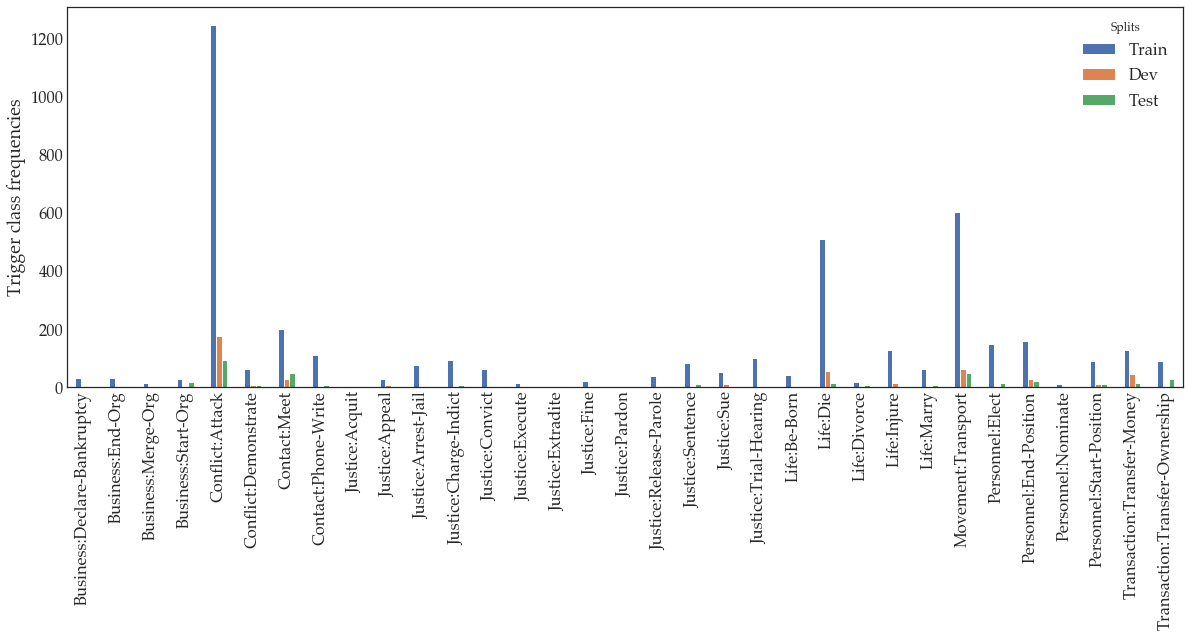

In [18]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(1, 1, figsize=(20,7))
    trigger_plot = trigger_stats_df.T.plot.bar(ax=ax)
    ax.set_ylabel('Trigger class frequencies')
    trigger_plot.set_xticklabels(trigger_plot.get_xticklabels(), rotation = 90)
    handles, labels = ax.get_legend_handles_labels()
    fig.savefig(SAVE_PATH.joinpath('ACE-Event_Stats.pdf'), bbox_inches='tight')

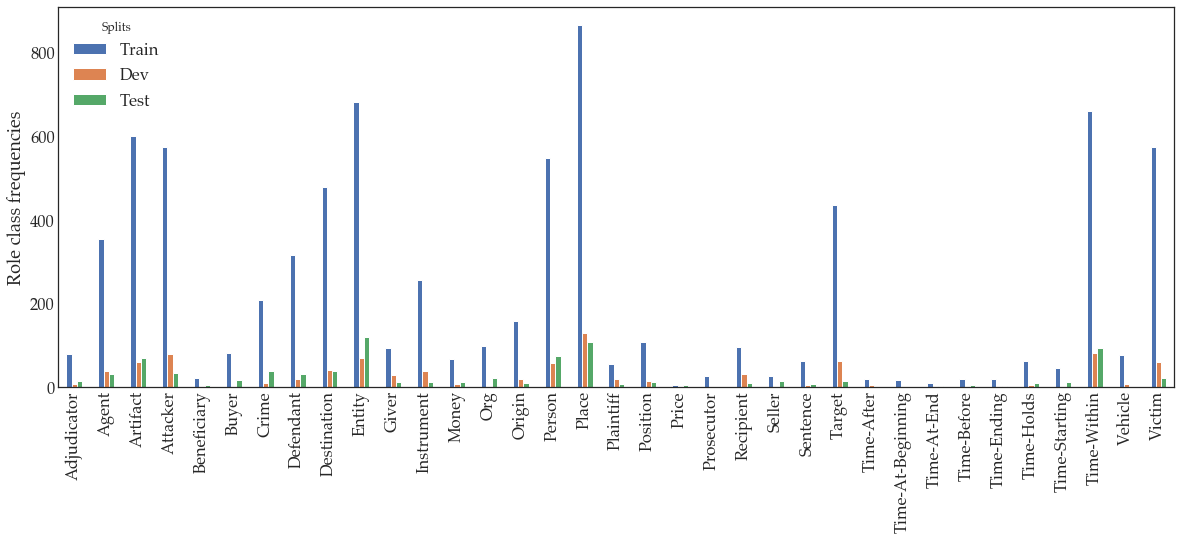

In [19]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(1, 1, figsize=(20,7))
    role_plot = role_stats_df.T.plot.bar(ax=ax)
    ax.set_ylabel('Role class frequencies')
    role_plot.set_xticklabels(role_plot.get_xticklabels(), rotation = 90)
    handles, labels = ax.get_legend_handles_labels()
    fig.savefig(SAVE_PATH.joinpath('ACE-Role_Stats.pdf'), bbox_inches='tight')